#### 猫-狗分类网络的改进：数据增广 ####

**图像数据导入为dataset**

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dir = 'cats_and_dogs_small/train'
validation_dir = 'cats_and_dogs_small/validation'
test_dir = 'cats_and_dogs_small/test'

train_dataset = image_dataset_from_directory(train_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')
validation_dataset = image_dataset_from_directory(validation_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')
test_dataset = image_dataset_from_directory(test_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**构建数据增广网络**

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models

data_augmentation = models.Sequential(name='Data_Augmentation')
data_augmentation.add(layers.Input(shape=(150,150,3)))
data_augmentation.add(layers.RandomRotation(factor=(-0.12,+0.12)))
data_augmentation.add(layers.RandomFlip(mode='horizontal'))
data_augmentation.add(layers.RandomZoom(height_factor=(-0.2, 0.2)))

data_augmentation.summary()

Model: "Data_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


**构建分类网络**
+ 将数据增广网络作为预处理层加入卷积神经网络
+ 增加一个Rescaling层，将图像像素变换到$[0,1]$

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

network = models.Sequential()
network.add(layers.Input(shape=(150,150,3)))
network.add(data_augmentation)
network.add(layers.Rescaling(1./255))
network.add(layers.Conv2D(32, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(128, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Data_Augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0

**学习网络**
+ 优化算法：RMSprop，学习率$0.0001$
+ 损失函数：binary_crossentropy
+ 以分类正确率作为度量指标
+ 学习30个回合，每个回合迭代100个batch，每个batch为20个训练样本
+ 学习样本为训练集dataset
+ 验证集dataset仅作为观察数据，每50次迭代观察一次

In [4]:
from tensorflow.keras import optimizers

network.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])
history = network.fit(train_dataset,steps_per_epoch=100,epochs=30, validation_data=validation_dataset,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 9s 50ms/step - loss: 0.6928 - acc: 0.5340 - val_loss: 0.6749 - val_acc: 0.5580
Epoch 2/30
100/100 [==============================] - 5s 53ms/step - loss: 0.6687 - acc: 0.5975 - val_loss: 0.6640 - val_acc: 0.5940
Epoch 3/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6438 - acc: 0.6320 - val_loss: 0.6165 - val_acc: 0.6610
Epoch 4/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6115 - acc: 0.6760 - val_loss: 0.6005 - val_acc: 0.6860
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6002 - acc: 0.6750 - val_loss: 0.6162 - val_acc: 0.6430
Epoch 6/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5841 - acc: 0.6915 - val_loss: 0.6020 - val_acc: 0.6610
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5747 - acc: 0.6980 - val_loss: 0.6069 - val_acc: 0.6610
Epoch 8/30
100/100 [==============================] - 5s 51ms/step - 

**测试网络**
+ 分别使用训练集、验证集和测试集评估网络

In [5]:
train_loss, train_acc = network.evaluate(train_dataset)
validation_loss, validation_acc = network.evaluate(validation_dataset)
test_loss, test_acc = network.evaluate(test_dataset)

print('\nTrain Accuracy:     ', train_acc)
print('Validation Accuracy:', validation_acc)
print('Test Accuracy:      ', test_acc)

50/50 [==============================] - 1s 15ms/step - loss: 0.5296 - acc: 0.7630

Train Accuracy:      0.8364999890327454
Validation Accuracy: 0.7720000147819519
Test Accuracy:       0.7630000114440918


**显示学习过程**

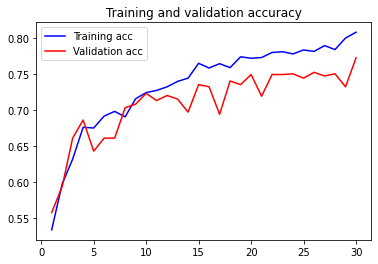

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()